In [2]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from coil_geometry import create_homo_geometry
import matplotlib.pyplot as plt
import numpy as np 

In [3]:
nwindings = 6  # Number of windings
wireradius = 0.001  # Radius of the wire
coilradius = 0.01  # Radius of the coil

# Geometrie laden
geo,_ = create_homo_geometry(nwindings, wireradius, coilradius)

In [4]:
mesh = Mesh(
    geo.GenerateMesh(maxh = 0.003)
)
mesh.Curve(1) 

In [5]:
print("Materialien im Mesh:", mesh.GetMaterials())
print("Randbedingungen im Mesh:", mesh.GetBoundaries())

Materialien im Mesh: ('coil', 'air')
Randbedingungen im Mesh: ('default', 'default', 'default', 'default', 'outer', 'outer', 'outer', 'outer', 'outer', 'outer')


In [6]:
# Konstanten
mu = 4 * pi * 1e-7      # Magnetische Feldkonstante (S.2)
sigma_coil = 5.87e7     # Leitfähigkeit Kupfer (S.11)
sigma_air = 0           # Leitfähigkeit Luft
k = 0.1                 # Regularisierungfaktor
i_c = 100               # Strom [A]

# Geometrische Parameter
A_c = pi * wireradius**2  
r = sqrt(x**2 + y**2 + z**2)

# Stromdichte j_c gemäß Aufgabenstellung
j_c = CoefficientFunction((
    (nwindings * i_c / A_c) * y / r,
    -(nwindings * i_c / A_c) * x / r,
    0
))

In [7]:
# H(curl)-Raum definieren
order = 2
V = HCurl(mesh, order=order-1, nograds=True, dirichlet="outer")
u, v = V.TnT()
gfA = GridFunction(V)


# Bilinearform und Linearform
a = BilinearForm(V, symmetric=True)
a += (1/mu) * InnerProduct(curl(u), curl(v)) * dx
a += k * InnerProduct(u, v) * dx

# Preconditioner
pre = Preconditioner(a, "multigrid")

# Linearform: Stromdichte
f = LinearForm(V)
f += InnerProduct(j_c, v) * dx("coil")

# Assemble
with TaskManager():
    a.Assemble()
    f.Assemble()

hcurl smoothingblocks, SmoothingType = 2


In [8]:
# Grösse von Gleichungsystems Elemente überprüfen
print(f"Matrix size: {a.mat.height} x {a.mat.width}")
print(f"Vector size: {f.vec.size}")
print(f"Präkonditionierer-Matrixgröße: {pre.mat.height} x {pre.mat.width}")

Matrix size: 274123 x 274123
Vector size: 274123
Präkonditionierer-Matrixgröße: 274123 x 274123


In [9]:
# Lösen des Gleichungssystems mit CG-Verfahren und Präkonditionierer (krylovspace.CGSolver)
inv = krylovspace.CGSolver(a.mat, pre.mat, tol=1e-12, printrates = True)

with TaskManager():
    gfA.vec.data = inv * f.vec

CG iteration 1, residual = 214.29723333314476     
CG iteration 2, residual = 0.8412436783137306     
CG iteration 3, residual = 0.004591120860491609     
CG iteration 4, residual = 3.122995662043405e-05     
CG iteration 5, residual = 2.56727525218943e-07     
CG iteration 6, residual = 2.4318438590048335e-09     
CG iteration 7, residual = 2.629659024186786e-11     


In [10]:
# Visualisierung
Draw(curl(gfA), mesh.Materials('coil'), "MagneticField")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [11]:
# Calculate the residual manually
residual_vec = f.vec - a.mat * gfA.vec
residual_norm = residual_vec.Norm()
print(f"Residual norm: {residual_norm}")

Residual norm: 263.87316961875337


In [12]:
B = curl(gfA)

In [13]:
# Feldlinien to be done 
yiB = np.linspace(-.005,.005,9)
XiB, YiB = np.meshgrid(yiB,yiB)
fieldlines = B._BuildFieldLines(mesh, np.array([XiB.flatten(),
    YiB.flatten(),np.zeros_like(XiB.flatten())]).T,
    num_fieldlines=10**3//5, randomized=False,
    length=1.,thickness=8e-4)
Draw (B, mesh.Materials('coil'), objects=[fieldlines],
      draw_surf=False,
      min=0, max=0.1,
      settings={"Objects": {"Edges": False, "Surface": True,
                            "Wireframe": False}})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Edges': False, …

BaseWebGuiScene

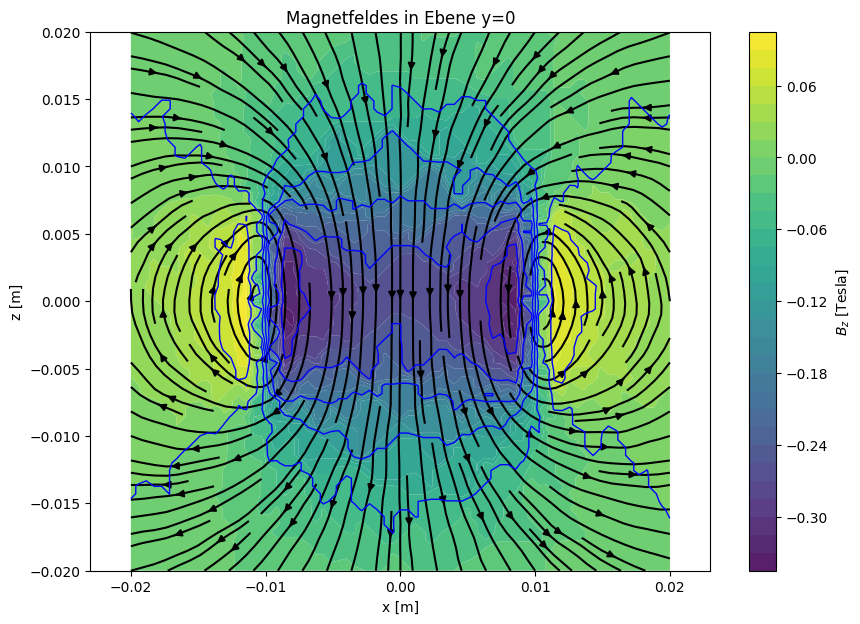

In [ ]:
# B_value = B(mesh(0,0,0))
# print(B_value)
# print(type(B_value))
# print(type(B_value[0]))

nx = 71
nz = 71

# Bereich für x und z festlegen (z.B. ±0.02 m)
lim = 0.02
xvals = np.linspace(-lim, lim, nx)
zvals = np.linspace(-lim, lim, nz)

# Meshgrid anlegen, für (X,Z)
X, Z = np.meshgrid(xvals, zvals)

# Arrays für Bx (U), Bz (V) und Bz (Mag) anlegen
U = np.zeros_like(X)
V = np.zeros_like(X)
Bz = np.zeros_like(X)  # Für Bz-Komponente

# Schleife über Gitterpunkte und B(x, y=0, z) auswerten
for i in range(nz):
    for j in range(nx):
        x = X[i, j]
        z = Z[i, j]

        B_val = B(mesh(x, 0, z))  # => B_val ist (Bx, By, Bz)
        U[i, j] = B_val[0]       # x-Komponente
        V[i, j] = B_val[2]       # z-Komponente
        Bz[i, j] = B_val[2]      # z-Komponente

        
plt.figure(figsize=(10, 7))
plt.title("Magnetfeldes in Ebene y=0")

# Hintergrundkontur für Bz
cont = plt.contourf(X, Z, Bz, levels=30,
                    cmap="viridis",
                    alpha=0.9,
                    antialiased=True)
plt.colorbar(cont, label="$B_z$ [Tesla]")

# Stromlinienplot (Feldlinien)
plt.streamplot(X, Z, U, V, color='k', density=1.5)

# Isolinien für Bz
plt.contour(X, Z, Bz, colors='blue', linewidths=1.0, linestyles='solid')

plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.show()

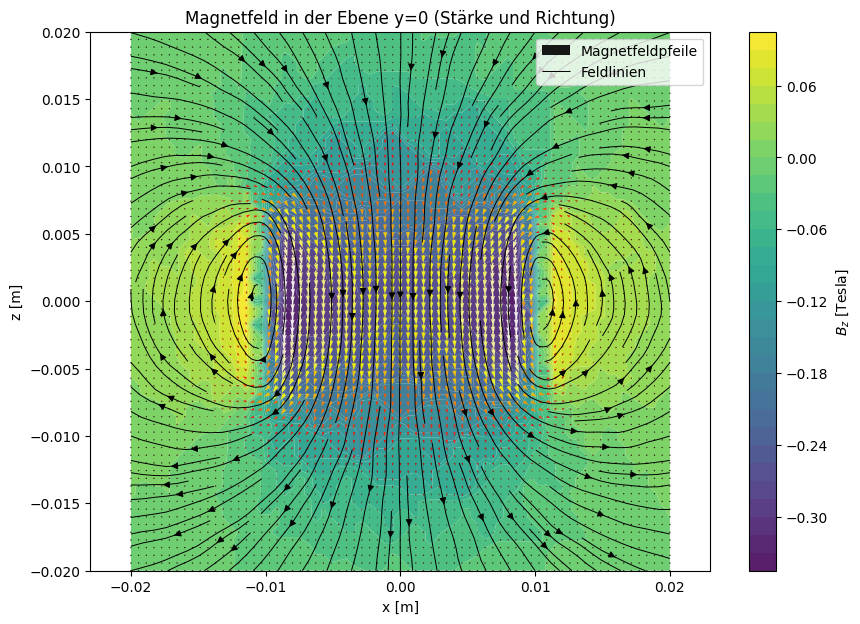

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Anzahl der Punkte im Gitter
nx = 71
nz = 71

# Bereich für x und z festlegen (z.B. ±0.02 m)
lim = 0.02
xvals = np.linspace(-lim, lim, nx)
zvals = np.linspace(-lim, lim, nz)

# Meshgrid anlegen, für (X,Z)
X, Z = np.meshgrid(xvals, zvals)

# Arrays für Bx (U), Bz (V) und Magnetfeldstärke (Mag) anlegen
U = np.zeros_like(X)
V = np.zeros_like(X)
Mag = np.zeros_like(X)  # Betrag des Magnetfelds

# Schleife über Gitterpunkte und Magnetfeld auswerten
for i in range(nz):
    for j in range(nx):
        x = X[i, j]
        z = Z[i, j]

        B_val = B(mesh(x, 0, z))  # B_val enthält (Bx, By, Bz)
        U[i, j] = B_val[0]       # x-Komponente
        V[i, j] = B_val[2]       # z-Komponente
        Mag[i, j] = np.sqrt(B_val[0]**2 + B_val[2]**2)  # Magnetfeldstärke

# Plot erstellen
plt.figure(figsize=(10, 7))
plt.title("Magnetfeld in der Ebene y=0 (Stärke und Richtung)")

# Hintergrundkontur für Bz
cont = plt.contourf(X, Z, Bz, levels=30, cmap="viridis", alpha=0.9, antialiased=True)
plt.colorbar(cont, label="$B_z$ [Tesla]")

# Pfeile für Magnetfeld (Länge proportional zur Stärke)
plt.quiver(X, Z, U, V, Mag, scale=20, cmap="hot", label="Magnetfeld $\\mathbf{B}$")

# Stromlinienplot (Feldlinien)
plt.streamplot(X, Z, U, V, color='k', density=1.5, linewidth=0.7)

# Layout
plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.legend(["Magnetfeldpfeile", "Feldlinien"], loc='upper right')
plt.show()